# Relationship between solar radio flux F10.7 and sunspot number

### Team members:

Zakhar Yagudin, Skoltech, 2023 <br>
CRediT author statement: Software (lead), Writing - review & editing

Khasan Akhmadiev, Skoltech, 2023 <br>
CRediT author statement: Writing - original draft

Konstantin Zamansky, Skoltech, 2023 <br>
CRediT author statement: Visualization, Software, Writing - review & editing

https://beta.elsevier.com/researcher/author/policies-and-guidelines/credit-author-statement?trial=true

### Import libraries

In [4]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import Image

pd.options.plotting.backend = 'plotly'

### Download measurements

In [5]:
df =pd.read_csv('data_group5.txt', 
                header = None, 
                names = "year month# flux sunspot#".split(),
                decimal = '.', sep = '\s+')
df['datetime_column'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month#'].astype(str), format='%Y-%m')
df.head()

,year,month#,flux,sunspot#,datetime_column
0,1947,2,202.7,188.9,1947-02-01
1,1947,3,235.7,183.8,1947-03-01
2,1947,4,264.1,212.1,1947-04-01
3,1947,5,261.2,285.0,1947-05-01
4,1947,6,226.6,232.1,1947-06-01


### Figure 1. Main indicators of solar activity

In [6]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
date = df.datetime_column
fig.add_trace(go.Scatter(x = date, y = df.loc[:,'sunspot#'], name = 'sunspot #'), secondary_y= False)
fig.add_trace(go.Scatter(x = date, y = df.loc[:,'flux'], name = 'flux'), secondary_y = True)
fig.update_layout(template = 'simple_white', 
                  title = 'Visual representation of the mean sunspot# and solar flux',
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = 'Date',
                  yaxis_title = '<b>Sunspot count</b>, #',
                  yaxis2_title = '<b>solar radioflux at 10.7cm</b>, SFU',
                  yaxis2_range = [-20, 365],
                  yaxis_range = [-20, 365],
                  yaxis2_nticks = 4,
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_xanchor = 'right',
                  legend_x = 0.9,)
fig.show()

In [7]:
fig.write_image("Visual representation.png", format = 'png', scale = 2)

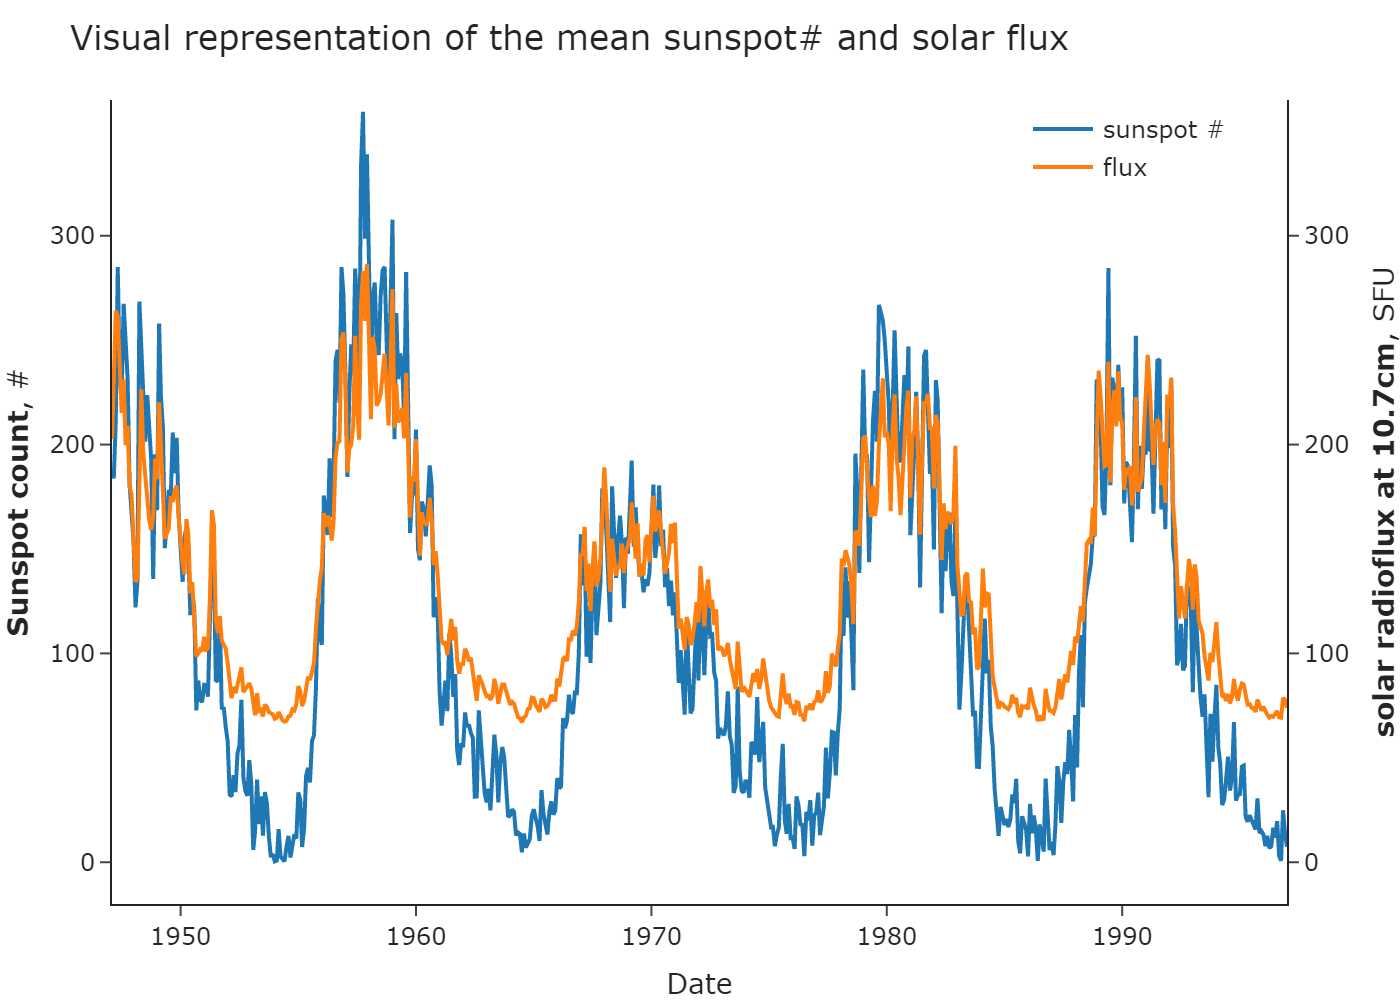

In [8]:
Image("Visual representation.png")

### 13-month running mean R

In [9]:
def run_mean(data, window_size=13):
    data = data.to_numpy()
    res = []
    for i in range(data.shape[0]-window_size):
        res.append((data[i] + data[i+window_size-1])/2/(window_size-1)+sum(data[i+1:i+window_size-2])/(window_size-1))
    return np.append(np.array(res), data[-window_size:])

### Figure 2. Smoothing of monthly mean data by 13 - month running mean

In [10]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
date = df.datetime_column
fig.add_trace(go.Scatter(x = date, y = run_mean(df.loc[:,'sunspot#']), name = 'sunspot #'), secondary_y= False)
fig.add_trace(go.Scatter(x = date, y = run_mean(df.loc[:,'flux']), name = 'flux'), secondary_y = True)
fig.update_layout(template = 'simple_white', 
                  title = 'Visual representation of the smoothed mean sunspot# and solar flux',
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = 'Date',
                  yaxis_title = '<b>Sunspot count</b>, #',
                  yaxis2_title = '<b>solar radioflux at 10.7cm</b>, SFU',
                  yaxis2_range = [-20, 365],
                  yaxis_range = [-20, 365],
                  yaxis2_nticks = 4,
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_xanchor = 'right',
                  legend_x = 0.9,)
fig.show()

In [11]:
fig.write_image("Visual representation_smoothed.png", format = 'png', scale = 2)

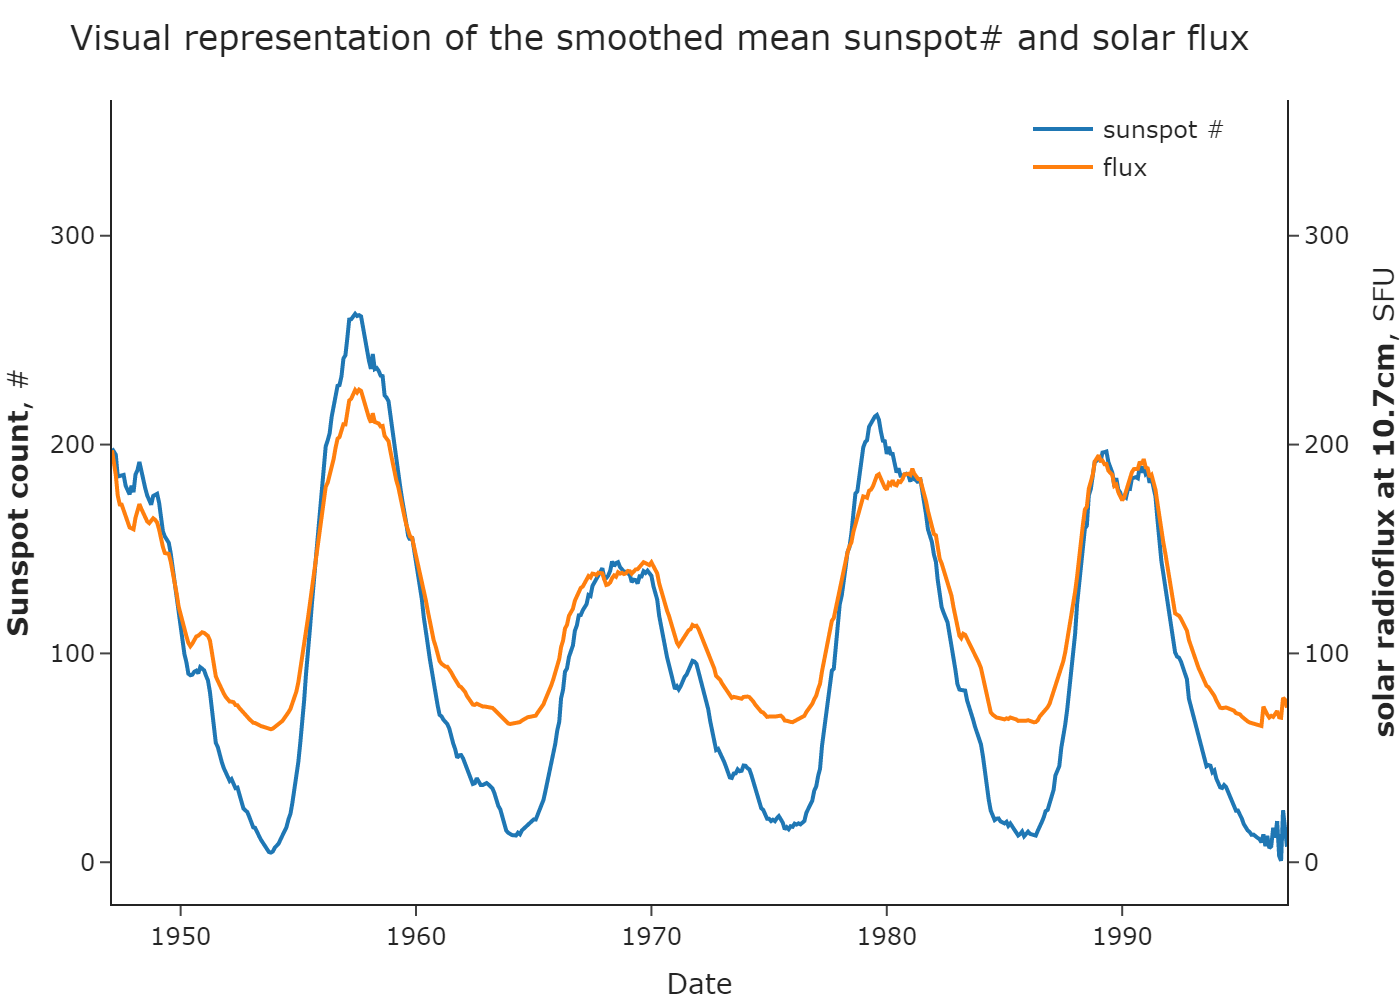

In [12]:
Image('Visual representation_smoothed.png')

### Construction of multi-dimensional linear regression

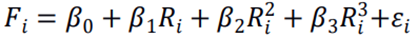 <br>
Here, <br>
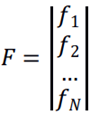 <br>
F - Vector of dependent variables, regressand, solar radio flux at 10.7 cm, <br>
f1, f2, …, fN - flux at different times.

In [13]:
def sample_function(coef):
    x = np.linspace(start = 0, stop = 359.4, num = 10000)
    func = lambda x: coef[0] + coef[1]*x + coef[2]*x**2 + coef[3]*x**3
    return func(x), x

### Matrix of regressors vector (independent variables)

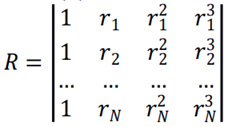 <br>
R - Matrix of independent variables, regressors, <br>
r1, r1, … rN - sunspot number at different times.


In [14]:
R = []
for r in run_mean(df['sunspot#']):
    row = [1, r, r**2, r**3]
    R.append(row)
f = np.array(run_mean(df['flux']))
R = np.array(R)

### Determine vector coefficients by LSM

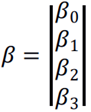 <br>
𝛽 - vector of coefficients

In [15]:
beta = np.linalg.pinv(R)@f

### Determine the variance of estimation error

In [16]:
print(f"coefficients for the apprximating cubic equation are \n{beta}")
print(f"\u03c32 = {np.var(f - R@beta)}")

coefficients for the apprximating cubic equation are 
[ 6.15111013e+01  3.83881805e-01  2.30130174e-03 -5.42100553e-06]
σ2 = 24.915999375348317


### Figure 3. Smoothing of monthly mean data by 13 - month running mean

In [17]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = df['sunspot#'], y = df['flux'], mode = 'markers', name = "real data"))
y, x = sample_function(beta)
fig.add_trace(go.Scatter(x = x, y= y, name = 'approximation', line_width = 5))
fig.add_annotation(text = f'<b>\u03c3<sup>2</sup></b> = {np.var(f - R@beta):.3f}', showarrow = False,
                   xref = 'paper', yref = 'paper', x = 0.9, y = 0.1, font_size = 25)
fig.update_layout(template = 'simple_white', 
                  title = 'Correlation between sunspot# and solar flux',
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>Sunspot count</b>, #',
                  yaxis_title = '<b>solar radioflux at 10.7cm</b>, SFU',
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_xanchor = 'left',
                  legend_x = 0.1,)
fig.show()
fig.write_image("Correlation.png", format = 'png', scale = 2)

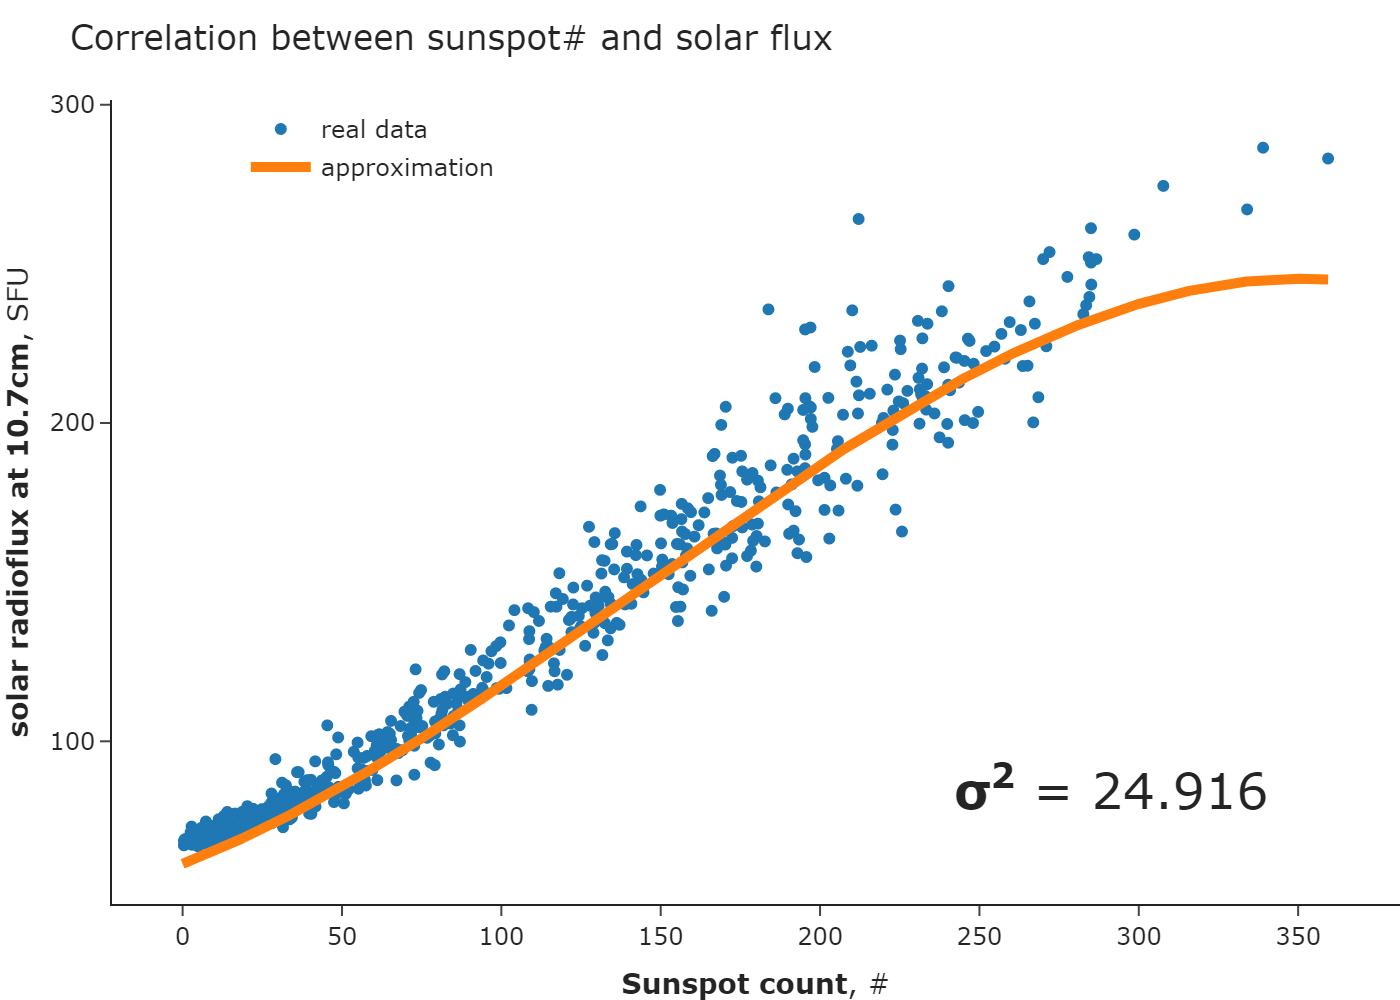

In [18]:
Image('Correlation.png')

There certainly is a correlation between sunspot count and solar flux at 10.7cm

In [19]:
func = lambda x: beta[0] + beta[1]*x + beta[2]*x**2 + beta[3]*x**3
smoothed = run_mean(df.loc[:,'flux'])
reconstructed = list(map(func, smoothed))

fig = go.Figure()
fig.add_trace(go.Scatter(x = date, y= reconstructed, name = 'reconstructed', line_width = 2))
fig.add_trace(go.Scatter(x = date, y= smoothed, name = 'smoothed', line_width = 2))
fig.add_annotation(text = f'<b>\u03c3<sup>2</sup></b> = {np.var(f - R@beta):.3f}', showarrow = False,
                   xref = 'paper', yref = 'paper', x = 0.9, y = 0.1, font_size = 25)
fig.update_layout(template = 'simple_white', 
                  title = 'Reconstructed radio flux',
                  margin = dict(t=50, b=0, l=50, r=0),
                  xaxis_title = '<b>date</b>',
                  yaxis_title = '<b>solar radioflux at 10.7cm</b>, SFU',
                  yaxis_nticks = 4,
                  legend_title = '',
                  legend_xanchor = 'left',
                  legend_x = 0.9,)
fig.show()
fig.write_image("Reconstructed.png", format = 'png', scale = 2)

Based on a cubic function approximation of the correlation between sunspot count and radio flux we were able to reconstruct the solar radioflux based on a sunspot count data with moderate variance of reconstructed results from the true ones

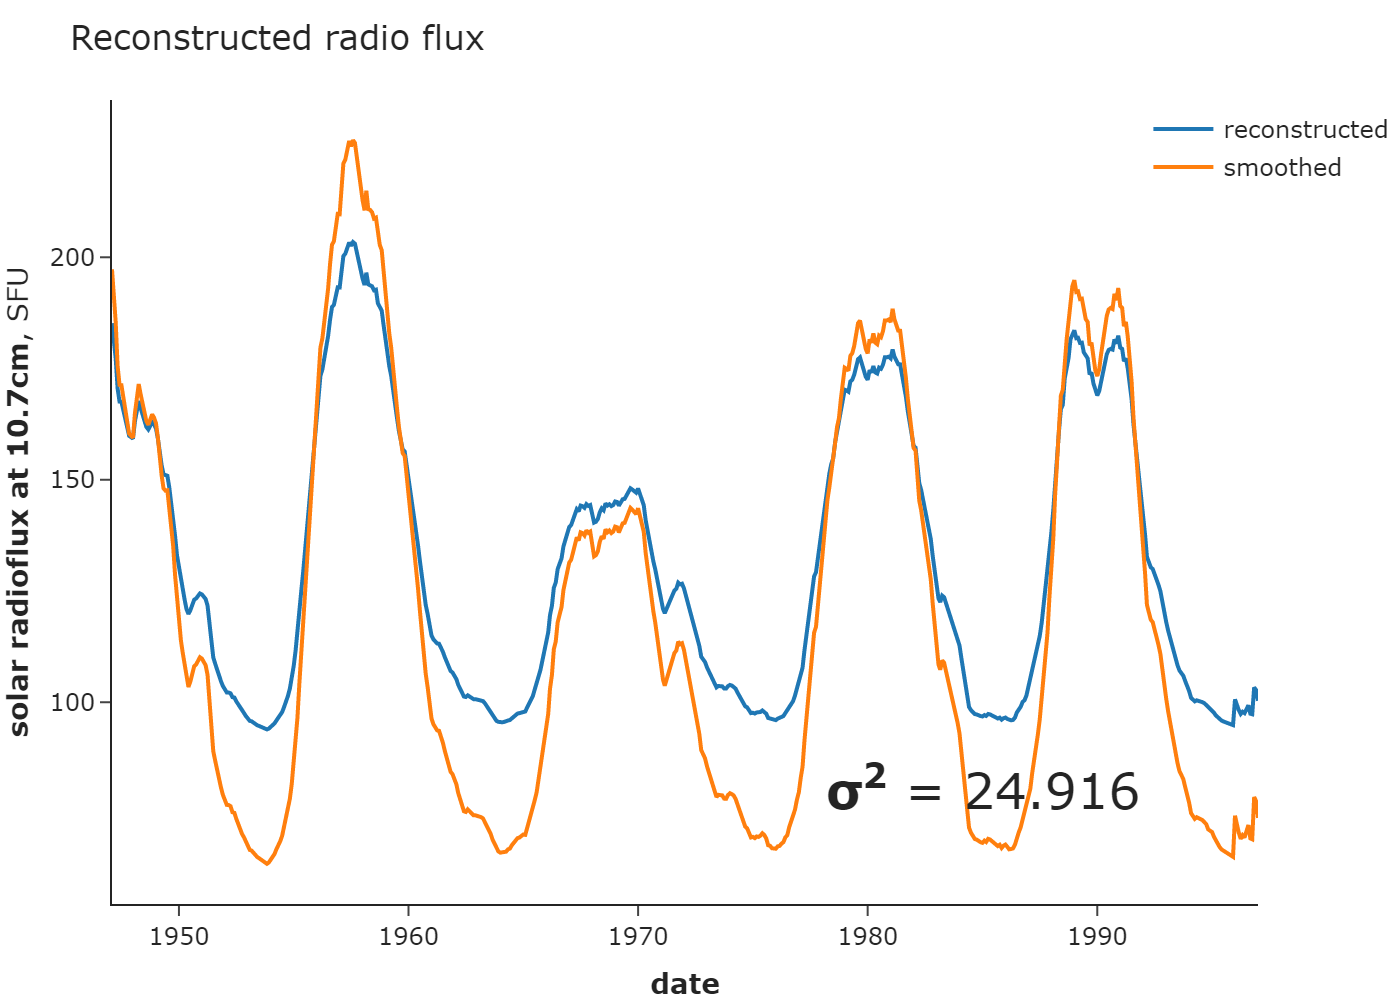

In [20]:
Image('Reconstructed.png')

**Conclusion:** <br>
&nbsp;&nbsp; First step was to visualize obtained data that was shown in Figure 1, analyze and highlight some patterns. As can be noticed, the increase of sunspot number is connected with the increase of solar radio flux. Also, the periodicity of the system is approximately 11 years. <br>
&nbsp;&nbsp; Making a scatter plot between monthly mean sunspot number and solar radio flux, the linear relationship between solar activity indicators is observed. <br>
&nbsp;&nbsp; After that, the 13-month running mean smoothing is applied to the data and results are shown in Figure 3. <br>
&nbsp;&nbsp; For estimating the error between smoothed and measured data, the multi-dimensional linear regression is constructed. The independent variables, including matrix of regressors vector, and the dependent variables, including vector of regressands, are determined. The vector of coefficients by LSM is determined according to the given equation: <br><br>
&nbsp;&nbsp; Using construction of multi-dimensional linear regression of smoothed and measured data, the variance of estimation error of solar radio flux is obtained and equals: σ<sup>2</sup> = 24.9 <br>
&nbsp;&nbsp; As shown on the plot of sunspot count relative to flux, we can observe almost linear dependency. But, it can be noticed that data distribution has some curvature on end points, thus, we can approximate data as a cubic function. <br>
